In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [42]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%%time
df=pd.read_excel('Bitcoins Filtered.xlsx')
df = df.sample(n=100000, random_state=10)
df.head()

Wall time: 2min 12s


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
360526,FREE PALESTINE ðŸ‡µðŸ‡¸,NaN,09/09/2017 DIAMOND EDGE IN KL,2013-04-10 08:18:54,468,1887,67057,False,2021-07-23 15:33:28,Olympic Tokyoâ€™s opening ceremony is on anoth...,"['Olympics', 'OpeningCeremony', 'OlympicGames'...",Twitter for iPhone,0.0
453093,anonymousfreeman,NaN,#cardano #ergo lover wants $Ada becoming the c...,2021-01-02 12:00:14,9,91,297,False,2021-07-21 19:20:39,@elonmusk says @SpaceX owns #Bitcoin ðŸš€ðŸ˜€\...,"['Bitcoin', 'Bitcoin', 'TheBWord']",Twitter for iPhone,0.0
590471,Sona Mailk,NaN,NaN,2021-03-11 18:14:30,10,39,17,False,2021-07-23 16:44:07,@krenovator Nice project\n@Anand00736867 \n@ku...,"['AirdropCrypto', 'Krenovator', 'BTC', 'Ethere...",Twitter for Android,0.0
246965,Mempool Whales ðŸ‹,Mempool,I'm hunting whales in the #bitcoin mempool Fol...,2021-03-31 21:03:05,217,56,427,False,2021-06-20 22:09:05,ðŸ‹\n373 #BTC (13.045.324 USD) will be transf...,"['BTC', 'bitcoin']",mempoolBot,0.0
423743,WhaleTrades ðŸ³,NaN,Whale-Watch-Bot Keeping You Connected To Crypt...,2018-02-28 10:32:22,105615,0,372,False,2021-07-22 17:30:40,"ðŸ“‰ðŸ’´$2,450,638 #bitcoin SHORTED @$32351.84...",['bitcoin'],Bitmex High Trades,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 360526 to 417278
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_name         99996 non-null   object        
 1   user_location     54733 non-null   object        
 2   user_description  89393 non-null   object        
 3   user_created      100000 non-null  datetime64[ns]
 4   user_followers    100000 non-null  int64         
 5   user_friends      100000 non-null  int64         
 6   user_favourites   100000 non-null  object        
 7   user_verified     100000 non-null  object        
 8   date              100000 non-null  object        
 9   text              100000 non-null  object        
 10  hashtags          97561 non-null   object        
 11  source            99510 non-null   object        
 12  is_retweet        99995 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(9)


In [5]:

df.drop('user_location', axis=1, inplace=True)

In [6]:
df=df.drop(columns=['user_favourites','user_description','hashtags','is_retweet'])

In [7]:
df['user_name']=df['user_name'].fillna(df['user_name'].mode()[0])

In [8]:
df['source'].value_counts()

Twitter for Android    26935
Twitter Web App        26916
Twitter for iPhone     19741
IFTTT                   1642
dlvr.it                 1329
                       ...  
erased21435079             1
MavSocial App              1
Crypto Crypto News         1
eBookLingo.com             1
BizToc                     1
Name: source, Length: 690, dtype: int64

In [9]:
source_list = ['Twitter Web App', 'Twitter for Android', 'Twitter for iPhone']

for index, row in df.iterrows():
    if row['source'] not in source_list:
        df.at[index, 'source'] = 'Others'

In [10]:
df['date']=pd.to_datetime(df['date'])

In [11]:
df.rename(columns={'date':'Date'},inplace=True)

In [12]:
from datetime import datetime

current_date = datetime.now().date()

df['user_created']=(current_date - df['user_created'].dt.date).dt.days

In [13]:
df['Date']=df['Date'].dt.date

 the decision of whether or not to add a weightage column is a trade-off between accuracy and complexity. In some cases, adding a weightage column can significantly improve the accuracy of a sentiment analysis model. However, in other cases, it may not make a significant difference or may even make the model more difficult to train.


# **bitcoin price**

In [15]:
df1=pd.read_csv('bitcoin_prices.csv')
df1.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 31, 2021","41,553.7","42,201.4","42,285.3","41,066.4",44.65K,-1.54%
1,"Jul 30, 2021","42,203.4","40,001.1","42,264.4","38,358.4",98.45K,5.50%
2,"Jul 29, 2021","40,001.4","40,009.0","40,630.7","39,340.8",75.30K,-0.00%
3,"Jul 28, 2021","40,003.2","39,450.4","40,862.2","38,883.8",148.92K,1.40%
4,"Jul 27, 2021","39,452.0","37,294.3","39,455.9","36,427.4",100.24K,5.84%


In [16]:
df1=df1.drop(columns=['Vol.'])

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      212 non-null    object
 1   Price     212 non-null    object
 2   Open      212 non-null    object
 3   High      212 non-null    object
 4   Low       212 non-null    object
 5   Change %  212 non-null    object
dtypes: object(6)
memory usage: 10.1+ KB


In [18]:
df1['Date']=pd.to_datetime(df1['Date'])

In [19]:
df1['Price']=df1['Price'].str.replace(',','')
df1['Price']=df1['Price'].astype(float)

df1['Open']=df1['Open'].str.replace(',','')
df1['Open']=df1['Open'].astype(float)

df1['High']=df1['High'].str.replace(',','')
df1['High']=df1['High'].astype(float)

df1['Low']=df1['Low'].str.replace(',','')
df1['Low']=df1['Low'].astype(float)

df1['Change %']=df1['Change %'].str.replace('%','')

df1['Change %']=df1['Change %'].astype(float)

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      212 non-null    datetime64[ns]
 1   Price     212 non-null    float64       
 2   Open      212 non-null    float64       
 3   High      212 non-null    float64       
 4   Low       212 non-null    float64       
 5   Change %  212 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.1 KB


In [21]:
df1[df1['Price']==df1['Price'].max()]

,Date,Price,Open,High,Low,Change %
109,2021-04-13,63540.9,59863.6,63659.0,59839.4,6.14


In [22]:
df1[df1['Price']==df1['Price'].min()]

,Date,Price,Open,High,Low,Change %
211,2021-01-01,29359.9,28951.7,29627.1,28712.4,1.42


In [23]:
df1['Date']=df1['Date'].dt.date

In [24]:
df['Date'].max()

datetime.date(2021, 7, 30)

In [25]:
df1['Date'].max()

datetime.date(2021, 7, 31)

In [26]:
dfnew=pd.merge(left=df,right=df1,how='left',on='Date')

In [27]:
dfnew.isnull().sum().sum()

0

In [28]:
dfnew.head()

,user_name,user_created,user_followers,user_friends,user_verified,Date,text,source,Price,Open,High,Low,Change %
0,FREE PALESTINE ðŸ‡µðŸ‡¸,3816,468,1887,False,2021-07-23,Olympic Tokyoâ€™s opening ceremony is on anoth...,Twitter for iPhone,33603.3,32297.9,33605.6,32041.1,4.04
1,anonymousfreeman,992,9,91,False,2021-07-21,@elonmusk says @SpaceX owns #Bitcoin ðŸš€ðŸ˜€\...,Twitter for iPhone,32131.4,29794.7,32794.6,29519.3,7.85
2,Sona Mailk,924,10,39,False,2021-07-23,@krenovator Nice project\n@Anand00736867 \n@ku...,Twitter for Android,33603.3,32297.9,33605.6,32041.1,4.04
3,Mempool Whales ðŸ‹,904,217,56,False,2021-06-20,ðŸ‹\n373 #BTC (13.045.324 USD) will be transf...,Others,35595.8,35510.9,36097.9,33378.0,0.23
4,WhaleTrades ðŸ³,2031,105615,0,False,2021-07-22,"ðŸ“‰ðŸ’´$2,450,638 #bitcoin SHORTED @$32351.84...",Others,32298.9,32131.7,32585.4,31729.4,0.52


In [29]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_name       100000 non-null  object 
 1   user_created    100000 non-null  int64  
 2   user_followers  100000 non-null  int64  
 3   user_friends    100000 non-null  int64  
 4   user_verified   100000 non-null  object 
 5   Date            100000 non-null  object 
 6   text            100000 non-null  object 
 7   source          100000 non-null  object 
 8   Price           100000 non-null  float64
 9   Open            100000 non-null  float64
 10  High            100000 non-null  float64
 11  Low             100000 non-null  float64
 12  Change %        100000 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 10.7+ MB


In [30]:
dfnew['user_verified'].value_counts()

False    99042
True       958
Name: user_verified, dtype: int64

In [31]:
dfnew['user_verified']=pd.get_dummies(dfnew['user_verified'],drop_first=True)

In [32]:
dfnew['user_verified']=dfnew['user_verified'].astype(int)

In [33]:
dfnew['user_verified'].value_counts()

0    99042
1      958
Name: user_verified, dtype: int64

In [34]:
dfnew['source'].value_counts()

Twitter for Android    26935
Twitter Web App        26916
Others                 26408
Twitter for iPhone     19741
Name: source, dtype: int64

In [35]:
dfnew['source']=dfnew['source'].replace({'Others': 1, 'Twitter Web App': 2,'Twitter for Android':3,'Twitter for iPhone':4})

In [36]:
dfnew['source'].value_counts()

3    26935
2    26916
1    26408
4    19741
Name: source, dtype: int64

In [37]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_name       100000 non-null  object 
 1   user_created    100000 non-null  int64  
 2   user_followers  100000 non-null  int64  
 3   user_friends    100000 non-null  int64  
 4   user_verified   100000 non-null  int32  
 5   Date            100000 non-null  object 
 6   text            100000 non-null  object 
 7   source          100000 non-null  int64  
 8   Price           100000 non-null  float64
 9   Open            100000 non-null  float64
 10  High            100000 non-null  float64
 11  Low             100000 non-null  float64
 12  Change %        100000 non-null  float64
dtypes: float64(5), int32(1), int64(4), object(3)
memory usage: 10.3+ MB


# **Text cleaning**

In [38]:
dfnew['text']

0        Olympic Tokyoâ€™s opening ceremony is on anoth...
1        @elonmusk says @SpaceX owns #Bitcoin ðŸš€ðŸ˜€\...
2        @krenovator Nice project\n@Anand00736867 \n@ku...
3        ðŸ‹\n373 #BTC (13.045.324 USD) will be transf...
4        ðŸ“‰ðŸ’´$2,450,638 #bitcoin SHORTED @$32351.84...
                               ...                        
99995    â¬‡ï¸ Seller alert: 10 $BTC sold into the bid...
99996    #bitcoin potential Wyckoff accumulation#1 as w...
99997    Bitcoin just reached $1 Trillion in Market Cap...
99998    Work with truly exceptional people who will v....
99999    'I Might Pump, But I Don't Dump'-- #Elonmusk\n...
Name: text, Length: 100000, dtype: object

In [39]:
#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [44]:
cleantext=[]
for item in tqdm(dfnew['text']):
    words=tweet_to_words(item)
    cleantext+=[words]


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [12:03<00:00, 138.23it/s]


In [45]:
dfnew['cleantext']=cleantext

In [46]:
dfnew['cleantext'].head()

0    [olymp, tokyo, open, ceremoni, anoth, level, b...
1    [elonmusk, say, spacex, own, bitcoin, right, t...
2    [krenov, nice, project, anand00736867, kumar37...
3    [373, btc, 13, 045, 324, usd, transfer, unknow...
4    [2, 450, 638, bitcoin, short, 32351, 84, 22, 0...
Name: cleantext, dtype: object

In [ ]:
# create a function to clean the tweets
def cleanTwt(twt):
    twt = re.sub("#bitcoin", 'bitcoin', twt) # removes the '#' from bitcoin
    twt = re.sub("#Bitcoin", 'Bitcoin', twt) # removes the '#' from Bitcoin
    #twt=re.sub('@â€™ðŸš€ðŸ˜€','',twt)
    twt = re.sub('#[A-Za-z0-9]+', '', twt) # removes any string with a '#'
    #twt = re.sub('@[A-Za-z0-9]+', '', twt) # removes any string with a '@'
    twt = re.sub('\\n', '', twt) # removes the '\n' string
    twt = re.sub('https:\/\/\S+', '', twt) # removes any hyperlinks
    return twt

In [ ]:
dfnew['cleanedtext_2'] = dfnew['text'].apply(cleanTwt)

In [ ]:
#text clean 3

In [ ]:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
pd.set_option('display.max_colwidth', 150)

def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [ ]:
dfnew['clean_text3']=dfnew['text'].apply(lambda x: tweet_to_words(x))

In [47]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [48]:
dfnew['cleantext']=dfnew['cleantext'].apply(unlist)

In [ ]:
dfnew['clean_text3']=dfnew['clean_text3'].apply(unlist)

# #**emojis**

In [ ]:
pip install emoji

In [ ]:
# failed to seprate emoji

# Sentiment scores

## **Textblob**

In [49]:
from textblob import TextBlob

In [ ]:
# A positive sentiment typically has a polarity score greater than 0.
# A negative sentiment typically has a polarity score less than 0.
# A neutral sentiment typically has a polarity score close to 0.

In [52]:
tweets = dfnew['cleantext']


sentiment_scores = []

for tweet in tweets:
    analysis = TextBlob(tweet)
    sentiment_score = analysis.sentiment.polarity
    sentiment_scores.append(sentiment_score)

dfnew['sentiment_scores_tb']=sentiment_scores

In [162]:
dfnew['sentiment_scores_tb'].min(),dfnew['sentiment_scores_tb'].max()

(-1.0, 1.0)

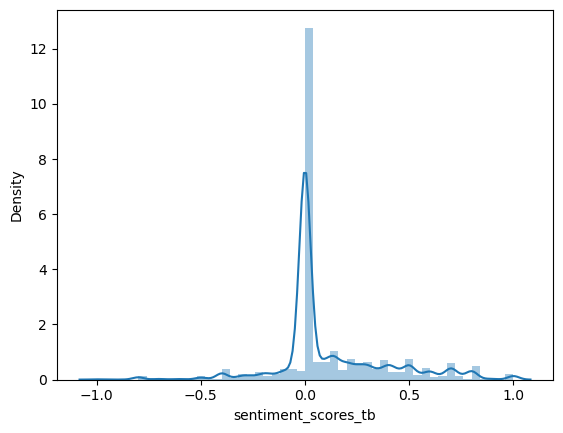

In [57]:
sns.distplot(dfnew['sentiment_scores_tb'])
plt.show()

## **NLTK**

In [ ]:
# The compound score typically ranges from -1 (very negative) to 1 (very positive),
# with values closer to -1 indicating negative sentiment and values closer to 1 indicating positive sentiment.
# A score close to 0 suggests a neutral sentiment.

In [54]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Example list of tweets
tweets = dfnew['cleantext']

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentiment_scores = []

for tweet in tweets:
    sentiment_score = sid.polarity_scores(tweet)['compound']
    sentiment_scores.append(sentiment_score)


dfnew['sentiment_scores_nltk']=sentiment_scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\riddh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [161]:
dfnew['sentiment_scores_nltk'].min(),dfnew['sentiment_scores_nltk'].max()

(-0.9741, 0.9837)

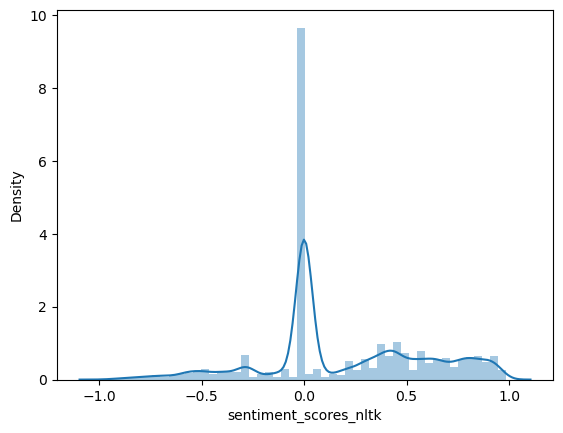

In [56]:
sns.distplot(dfnew['sentiment_scores_nltk'])
plt.show()

# roberta

In [181]:
from transformers import pipeline

# Load the pre-trained RoBERTa model for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis", model="roberta-base")

# Initialize an empty list to store sentiment scores
sentiment_scores = []

# Loop through the cleaned text data in your DataFrame (change 'cleantext' to the actual column name)
for text in dfnew['cleantext']: 
    # Perform sentiment analysis and get the sentiment score
    results = sentiment_analyzer(text)
    sentiment_score = results[0]['score']  # Extract the sentiment score from the results
    sentiment_scores.append(sentiment_score)


dfnew['sentiment_scores_roberta']=sentiment_scores




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
#system crashed!

In [182]:
dfnew[['sentiment_scores_nltk','sentiment_scores_tb']]

,sentiment_scores_nltk,sentiment_scores_tb
0,0.5859,0.450000
1,0.3818,0.442857
2,0.4215,0.600000
3,0.0000,-0.100000
4,-0.5423,0.000000
...,...,...
99995,0.2960,0.000000
99996,0.2732,-0.125000
99997,0.0258,0.000000
99998,0.0000,0.000000


In [60]:
#dfnew.to_csv('sgbest.csv')

# Feature Engg 

In [170]:
def categorize_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

In [171]:
dfnew['sentiment_category_nltk'] = dfnew['sentiment_scores_nltk'].apply(categorize_sentiment)
dfnew['sentiment_category_tb'] = dfnew['sentiment_scores_tb'].apply(categorize_sentiment)

In [172]:
dfnew.head()

,user_name,user_created,user_followers,user_friends,user_verified,Date,text,source,Price,Open,High,Low,Change %,cleantext,sentiment_scores_tb,sentiment_scores_nltk,sentiment_category_nltk,sentiment_category_tb
0,FREE PALESTINE ðŸ‡µðŸ‡¸,3816,468,1887,0,2021-07-23,Olympic Tokyoâ€™s opening ceremony is on anoth...,4,33603.3,32297.9,33605.6,32041.1,4.04,olymp tokyo open ceremoni anoth level brillian...,0.450000,0.5859,positive,positive
1,anonymousfreeman,992,9,91,0,2021-07-21,@elonmusk says @SpaceX owns #Bitcoin ðŸš€ðŸ˜€\...,4,32131.4,29794.7,32794.6,29519.3,7.85,elonmusk say spacex own bitcoin right twitter ...,0.442857,0.3818,positive,positive
2,Sona Mailk,924,10,39,0,2021-07-23,@krenovator Nice project\n@Anand00736867 \n@ku...,3,33603.3,32297.9,33605.6,32041.1,4.04,krenov nice project anand00736867 kumar3726064...,0.600000,0.4215,positive,positive
3,Mempool Whales ðŸ‹,904,217,56,0,2021-06-20,ðŸ‹\n373 #BTC (13.045.324 USD) will be transf...,1,35595.8,35510.9,36097.9,33378.0,0.23,373 btc 13 045 324 usd transfer unknown wallet...,-0.100000,0.0000,neutral,negative
4,WhaleTrades ðŸ³,2031,105615,0,0,2021-07-22,"ðŸ“‰ðŸ’´$2,450,638 #bitcoin SHORTED @$32351.84...",1,32298.9,32131.7,32585.4,31729.4,0.52,2 450 638 bitcoin short 32351 84 22 07 21 17 3...,0.000000,-0.5423,negative,neutral


In [173]:
dfnew['sentiment_category_nltk'].value_counts()

positive    47151
neutral     37611
negative    15238
Name: sentiment_category_nltk, dtype: int64

In [174]:
dfnew['sentiment_category_tb'].value_counts()

neutral     50025
positive    38643
negative    11332
Name: sentiment_category_tb, dtype: int64


<div style="text-align:center; margin-top:40px; margin-bottom:40px;">
    <font color="blue">
        <font size="6">
            <b>Using Data Visualization to Find Insights in Data</b>
        </font>
    </font>
</div>



In [102]:
import plotly.express as px

In [74]:
(dfnew.groupby('Date')['text'].count()).plot(kind='bar')

-  Numbers of tweets are more in mounth of july 2021
- On 22 july 2021 there are max numbers of tweets  '6515'


In [157]:
(dfnew.groupby('Date')['sentiment_scores_tb'].mean()).plot(kind='bar')

In [159]:
(dfnew.groupby('Date')['sentiment_scores_nltk'].mean()).plot(kind='bar')

In [176]:
(dfnew.groupby('Date')['Change %'].mean()).plot(kind='bar')

In [175]:
(dfnew.groupby('Date')['Change %'].mean()).plot(kind='line')

- 21 jun 2021 there was sudden drop of bitcoin price of 10.97%
- 8 feb 2021 there was sudden rise of bitcoin price of 19.41%

# Price for each date 

In [154]:
(dfnew.groupby('Date')['Price'].mean()).plot(kind='line')

- Here we can see that 17 april 2021 bitcoin price touch 60K
- bitcoin touch the lowest on 20 july 2021 for 29.79k

In [205]:
(dfnew.groupby('sentiment_category_nltk')['Change %'].mean()).plot(kind='bar')

# HeatMap Correlation

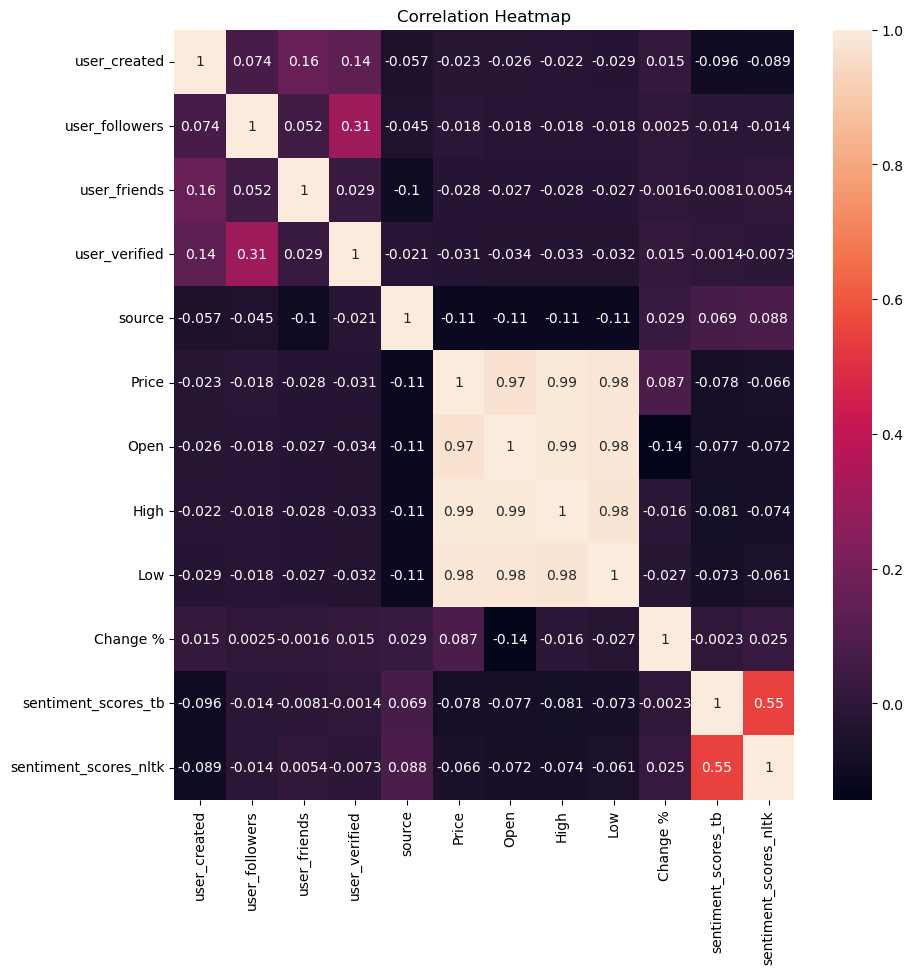

In [203]:
plt.figure(figsize=(10,10))
sns.heatmap(dfnew.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()


# 
<div style="text-align:center; margin-top:10px; margin-bottom:40px;">
    <font color="blue">
        <font size="6">
            <b>STATISTICAL ANALYSIS</b>
        </font>
    </font>
</div>

### Independent t-test (Comparing 'Price' between two groups of 'user_verified'):




- Null Hypothesis (H0): There is no significant difference in the mean 'Price' between the two groups of 'user_verified' (user verification status does not affect the cryptocurrency price).
- Alternative Hypothesis (H1): There is a significant difference in the mean 'Price' between the two groups of 'user_verified' (user verification status does affect the cryptocurrency price).

In [212]:
from scipy.stats import ttest_ind, f_oneway, chi2_contingency

group1 = dfnew[dfnew['user_verified'] == 0]['Price']
group2 = dfnew[dfnew['user_verified'] == 1]['Price']
t_stat, p_value = ttest_ind(group1, group2)
print(f"T-statistic: {t_stat}, p-value: {p_value}")


T-statistic: 9.734816734340614, p-value: 2.191673673241499e-22


In [213]:
p_value<0.05

True

In [ ]:
#we reject H0
#user verification status does affect the bitcoin price.

### user_followers vs Price


- Null Hypothesis (H0): There is no significant difference in the mean 'Price' between users with low 'user_followers'
    (below or equal to a certain threshold) and users with high 'user_followers' (above the threshold).

- Alternative Hypothesis (H1): There is a significant difference in the mean 'Price' between users with low 'user_followers'
   and users with high 'user_followers.

In [223]:
from scipy.stats import ttest_ind

# Dthreshold to categorize 'user_followers' into two groups 
threshold = 10000  

# Create two groups based on 'user_followers'
low_followers = dfnew[dfnew['user_followers'] <= threshold]['Price']
high_followers = dfnew[dfnew['user_followers'] > threshold]['Price']

t_statistic, p_value = ttest_ind(low_followers, high_followers)
alpha = 0.05  

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean Price between low and high user_followers.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in mean Price between low and high user_followers.")


T-statistic: 11.61672328554222
P-value: 3.5489530239312205e-31
Reject the null hypothesis: There is a significant difference in mean Price between low and high user_followers.


### ANOVA to compare 'Price' across 'sentiment_category_nltk'



- Null Hypothesis (H0): There is no significant difference in the mean 'Price' among the different categories of 'sentiment_category_nltk' (sentiment category does not affect the cryptocurrency price).

- Alternative Hypothesis (H1): There is a significant difference in the mean 'Price' among the different categories of 'sentiment_category_nltk' (sentiment category does affect the cryptocurrency price)


In [214]:


f_statistic, p_value = f_oneway(dfnew['Price'][dfnew['sentiment_category_nltk'] == 'positive'],
                                dfnew['Price'][dfnew['sentiment_category_nltk'] == 'negative'],
                                dfnew['Price'][dfnew['sentiment_category_nltk'] == 'neutral'])
print(f"F-statistic: {f_statistic}, p-value: {p_value}")


F-statistic: 527.2478977542534, p-value: 1.6521868389246743e-228


In [215]:
p_value<0.05

True

In [ ]:
#we reject H0
#sentiment category does affect the bitcoin price

### Performing ANOVA to compare 'Price' across 'source' categories

In [219]:
df['source'].value_counts()

Twitter for Android    26935
Twitter Web App        26916
Others                 26408
Twitter for iPhone     19741
Name: source, dtype: int64

In [221]:
dfnew['source'].value_counts()

3    26935
2    26916
1    26408
4    19741
Name: source, dtype: int64

In [222]:
f_statistic, p_value = f_oneway(
    dfnew[dfnew['source'] == 3]['Price'],
    dfnew[dfnew['source'] == 2]['Price'],
    dfnew[dfnew['source'] == 1]['Price'],
    dfnew[dfnew['source'] == 4]['Price'])


print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean Price among source categories.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in mean Price among source categories.")


F-statistic: 477.3412360035654
P-value: 5.280851675592129e-308
Reject the null hypothesis: There is a significant difference in mean Price among source categories.


# BUILDING MODELS

In [225]:
dfnew.columns

Index(['user_name', 'user_created', 'user_followers', 'user_friends',
       'user_verified', 'Date', 'text', 'source', 'Price', 'Open', 'High',
       'Low', 'Change %', 'cleantext', 'sentiment_scores_tb',
       'sentiment_scores_nltk', 'sentiment_category_nltk',
       'sentiment_category_tb'],
      dtype='object')

### Base model for  NLTK

In [231]:
import statsmodels.api as sma
from sklearn.model_selection import train_test_split

x=dfnew.drop(columns=['user_name','Date', 'text','Price', 'Open', 'High',
       'Low', 'Change %', 'cleantext','sentiment_scores_tb','sentiment_category_nltk',
       'sentiment_category_tb'])
xc=sma.add_constant(x)
y=dfnew['Price']

xtrain,xtest,ytrain,ytest=train_test_split(xc,y,random_state=10,test_size=0.3)




ols_model=sma.OLS(ytrain,xtrain).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     216.5
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          6.10e-275
Time:                        19:19:24   Log-Likelihood:            -7.2356e+05
No. Observations:               70000   AIC:                         1.447e+06
Df Residuals:                   69993   BIC:                         1.447e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   3.94e+

### Base model for  Textblob

In [232]:
import statsmodels.api as sma
from sklearn.model_selection import train_test_split

x=dfnew.drop(columns=['user_name','Date', 'text','Price', 'Open', 'High',
       'Low', 'Change %', 'cleantext','sentiment_scores_nltk','sentiment_category_nltk',
       'sentiment_category_tb'])
xc=sma.add_constant(x)
y=dfnew['Price']

xtrain,xtest,ytrain,ytest=train_test_split(xc,y,random_state=10,test_size=0.3)




ols_model=sma.OLS(ytrain,xtrain).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     238.9
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          2.18e-303
Time:                        19:19:26   Log-Likelihood:            -7.2349e+05
No. Observations:               70000   AIC:                         1.447e+06
Df Residuals:                   69993   BIC:                         1.447e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.944e+04    

### NOTE : Going with textblob sentiment score as it is giving good R2 as compare to NLTK

# ADDING Weightage column

In [292]:
w1 = 0.4
w2 = 0.3
w3 = 0.3

dfnew['Weightage'] = (
    w1 * (dfnew['user_created'] / dfnew['user_created'].max()) +
    w2 * np.where((dfnew['user_followers'] + dfnew['user_friends']) > 0, dfnew['user_followers'] / (dfnew['user_followers'] + dfnew['user_friends']), 0) +
    w3 * dfnew['user_verified']
)

# Min-Max scaling after handling division by zero
dfnew['Weightage'] = (dfnew['Weightage'] - dfnew['Weightage'].min()) / (dfnew['Weightage'].max() - dfnew['Weightage'].min())


# Scaling


In [266]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
ssdf=pd.DataFrame(ss.fit_transform(x.drop(columns=['sentiment_scores_tb'])),columns=x.drop(columns=['sentiment_scores_tb']).columns)
x=pd.concat((ssdf,x['sentiment_scores_tb']),axis=1)

xc=sma.add_constant(x)
xtrain,xtest,ytrain,ytest=train_test_split(xc,y,random_state=10,test_size=0.3)
ols_modelss=sma.OLS(ytrain,xtrain).fit()
print(ols_modelss.summary())



                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     247.0
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:11:22   Log-Likelihood:            -7.2335e+05
No. Observations:               70000   AIC:                         1.447e+06
Df Residuals:                   69992   BIC:                         1.447e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.716e+04    

# Check the Assumptions of the Linear Regression

### 1. Normality of Residuals


- The assumption of normality is an important assumption for many statistical tests. The normal Q-Q plot is one way to assess normality. This q-q or quantile-quantile is a scatter plot which helps us validate the assumption of normal distribution in a data set.

In [263]:
from scipy.stats import jarque_bera
resid = ols_modelss.resid
jarque_bera(resid)

Jarque_beraResult(statistic=37373.31336637752, pvalue=0.0)

In [ ]:
#reject the Ho, hence the data is not normal

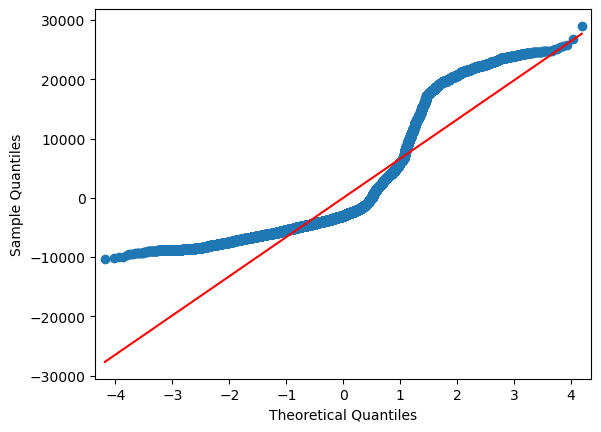

In [260]:
from statsmodels.graphics.gofplots import qqplot

resid = ols_modelss.resid
qqplot(resid,line='r')
plt.show()

- Using this plot, we can infer that the residuals do not come from a normal distribution. Also Jarqque Bera test suggests residuals do not come from a normal distribution. This is possible since our target variable is not normally distributed

### 2.Detecting Autocorrelation

In [262]:
sma.stats.stattools.durbin_watson(ols_modelss.resid)

2.006290344220603


 
DW Statistic ≈ 2: This indicates little to no autocorrelation in the residuals. In other words, the residuals are approximately uncorrelated with each other.

DW Statistic < 2: This suggests positive autocorrelation in the residuals. The residuals tend to be positively correlated with their lagged values.

DW Statistic > 2: This suggests negative autocorrelation in the residuals. The residuals tend to be negatively correlated with their lagged values.


    -  Based on Durbin Watson score, we can conclude that there is no autocorrelation*

### 3.Detecting Heteroskedasticity

In [ ]:
H0: The residuals are homoskedastic
H1: The residuals are not homoskedastic

In [278]:
from statsmodels.stats.diagnostic import het_breuschpagan
_,_,_,p = het_breuschpagan(resid,xtrain)
p

1.2123558390609851e-288

In [ ]:
# Since p value is less than 0.05, there is hetroscedasticity

### 4. Multicolinearity VIF

In [277]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=[variance_inflation_factor(xtrain.values,i) for i in range(xtrain.shape[1])]
pd.DataFrame({'Vif':vif,'Columns':xtrain.columns}).sort_values('Vif', ascending=False)

,Vif,Columns
6,1.763666,Weightage
1,1.326981,user_created
4,1.304039,user_verified
5,1.188757,source
0,1.182603,const
2,1.121558,user_followers
3,1.042803,user_friends
7,1.039631,sentiment_scores_tb


In [ ]:
#No Multicolinearity present 

### 5.Linearity Assumption

- H0: Data has Linear Relationship with the Target Variable.
- H1: Data has non Linear releationship with target variable

In [281]:
rainbow_statistic, rainbow_p_value = sma.stats.linear_rainbow(ols_modelss)

if rainbow_p_value < 0.05:
    print("Reject the null hypothesis: Nonlinearity is present in the model.")
else:
    print("Fail to reject the null hypothesis: No significant evidence of nonlinearity.")

Fail to reject the null hypothesis: No significant evidence of nonlinearity.


In [ ]:
#Data has linear relation relation with Y variable.

##### I n this model, only  heteroscedasticity is present  other all 4 assumptions is satisfied 


### Significance of the model

In [239]:
# Ho: The model is insignificant
# Ha: The model is significant

if ols_modelss.f_pvalue > 0.05:
    print('Model is insignificant')
else:
    print('Model is significant')

print('Statistically significant columns: ')
for i in ols_modelss.pvalues.to_dict():
    if ols_modelss.pvalues.to_dict()[i]<0.05:
        print(i,end=', ')

Model is significant
Statistically significant columns: 
const, user_created, user_followers, user_friends, user_verified, source, sentiment_scores_tb, 

# Building Model 

In [242]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

In [299]:
x=dfnew.drop(columns=['user_name','Date', 'text','Price', 'Open', 'High',
       'Low', 'Change %', 'cleantext','sentiment_scores_nltk','sentiment_category_nltk',
       'sentiment_category_tb'])
y=dfnew['Price']

In [300]:
ss=StandardScaler()
ssdf=pd.DataFrame(ss.fit_transform(x.drop(columns=['sentiment_scores_tb','Weightage'])),columns=x.drop(columns=['sentiment_scores_tb','Weightage']).columns)
x=pd.concat((ssdf,x['sentiment_scores_tb'],dfnew['Weightage']),axis=1)





In [319]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=10,test_size=0.3)

In [320]:
x.head(1)

,user_created,user_followers,user_friends,user_verified,source,sentiment_scores_tb,Weightage
0,1.123356,-0.066448,0.100857,-0.09835,1.483563,0.45,0.1715


In [303]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor



# Initialize a list of regression models to test
models = [
    LinearRegression(),Ridge(),Lasso(), ElasticNet(),
    SGDRegressor(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

# Initialize empty lists to store results
model_names = []
train_r2_scores = []
test_r2_scores = []
train_rmse_values = []
test_rmse_values = []

# Iterate through the models
for model in models:
    model_name = str(model).split('(')[0]  # Extract the model name

    
    # Fit the model and make predictions for both train and test datasets
    model.fit(xtrain, ytrain)
    ypred_train = model.predict(xtrain)
    ypred_test = model.predict(xtest)
    
    # Calculate R2 scores for train and test
    train_r2 = r2_score(ytrain, ypred_train)
    test_r2 = r2_score(ytest, ypred_test)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
    # Calculate RMSE for train and test
    train_rmse = mean_squared_error(ytrain, ypred_train, squared=False)
    test_rmse = mean_squared_error(ytest, ypred_test, squared=False)
    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)
    
    model_names.append(model_name)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Train R2': train_r2_scores,
    'Test R2': test_r2_scores,
    'Train RMSE': train_rmse_values,
    'Test RMSE': test_rmse_values
})

In [304]:
results_df

,Model,Train R2,Test R2,Train RMSE,Test RMSE
0,LinearRegression,0.024109,0.024236,7440.052944,7404.814909
1,Ridge,0.024109,0.024236,7440.052957,7404.816109
2,Lasso,0.024108,0.024227,7440.058347,7404.847390
3,ElasticNet,0.014934,0.014278,7474.946994,7442.503691
4,SGDRegressor,0.023827,0.023428,7441.128732,7407.877587
5,KNeighborsRegressor,0.521500,0.260491,5209.745995,6446.343674
6,DecisionTreeRegressor,0.991877,0.061483,678.795251,7262.109099
7,RandomForestRegressor,0.921814,0.489927,2105.914676,5353.749941
8,AdaBoostRegressor,-0.000493,-0.000629,7533.249468,7498.567234
9,GradientBoostingRegressor,0.151138,0.145905,6938.952171,6927.790623


In [305]:
results_df.sort_values(by='Test R2',ascending=False).head()

,Model,Train R2,Test R2,Train RMSE,Test RMSE
7,RandomForestRegressor,0.921814,0.489927,2105.914676,5353.749941
10,XGBRegressor,0.447545,0.351673,5597.882005,6035.854974
5,KNeighborsRegressor,0.521500,0.260491,5209.745995,6446.343674
9,GradientBoostingRegressor,0.151138,0.145905,6938.952171,6927.790623
6,DecisionTreeRegressor,0.991877,0.061483,678.795251,7262.109099


# Fine Tuning

In [306]:
from sklearn.model_selection  import GridSearchCV

In [ ]:
# n_estimators=100,
#     criterion='gini',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,

In [307]:
%%time
para=[{'n_estimators':[200,300,500],
       'max_depth':[20,25,30],
       'min_samples_split':[1,2,5]}]

rfr=RandomForestRegressor(random_state=10)
rf_grid=GridSearchCV(estimator=rfr,cv=2,param_grid=para)

rfmodel=rf_grid.fit(xtrain,ytrain)
rfr=RandomForestRegressor(**rf_grid.best_params_)

rf_model=rfr.fit(xtrain,ytrain)

ypred_test=rf_model.predict(xtest)
ypred_train=rf_model.predict(xtrain)
print('R-Square test: ',r2_score(ytest,ypred_test))
print('R-Square train : ',r2_score(ytrain,ypred_train))
print('RMSE test: ',mean_squared_error(ytest,ypred_test)**0.5)
print('RMSE train: ',mean_squared_error(ytrain,ypred_train)**0.5)

R-Square test:  0.4917214847303698
R-Square train :  0.9060014526007325
RMSE test:  5344.322380360838
RMSE train:  2309.064025069973
Wall time: 58min 55s


In [308]:
rfmodel.best_params_

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 500}

# SFS

In [309]:
from mlxtend.feature_selection import SequentialFeatureSelector
rf=RandomForestRegressor()
sfs_forward= SequentialFeatureSelector(estimator=rf,k_features=5,forward=True,scoring='neg_root_mean_squared_error')
sfs_forward.fit(xtrain,ytrain)
sfs_forward.k_feature_names_


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
#('user_created', 'user_followers', 'user_friends', 'source', 'Weightage')

In [310]:
from mlxtend.feature_selection import SequentialFeatureSelector
rf=RandomForestRegressor()
sfs_forward= SequentialFeatureSelector(estimator=rf,k_features='best',forward=True,scoring='r2')
sfs_forward.fit(xtrain,ytrain)
sfs_forward.k_feature_names_


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
#('user_created','user_followers','user_friends','user_verified','source','Weightage')

In [321]:
dfnew.head(1)

,user_name,user_created,user_followers,user_friends,user_verified,Date,text,source,Price,Open,High,Low,Change %,cleantext,sentiment_scores_tb,sentiment_scores_nltk,sentiment_category_nltk,sentiment_category_tb,Weightage
0,FREE PALESTINE ðŸ‡µðŸ‡¸,3816,468,1887,0,2021-07-23,Olympic Tokyoâ€™s opening ceremony is on anoth...,4,33603.3,32297.9,33605.6,32041.1,4.04,olymp tokyo open ceremoni anoth level brillian...,0.45,0.5859,positive,positive,0.1715


In [322]:
dfnew.to_csv('sgbest_new.csv')

In [323]:
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5], 
    'learning_rate': [0.01, 0.1, 0.2],  
}

xgb_regressor = XGBRegressor()
xrf_grid = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
                           scoring='r2', cv=3)


xrfmodel=xrf_grid.fit(xtrain,ytrain)
xrfr=RandomForestRegressor(**rf_grid.best_params_)

xrf_model=xrfr.fit(xtrain,ytrain)

ypred_test=xrf_model.predict(xtest)
ypred_train=xrf_model.predict(xtrain)
print('R-Square test: ',r2_score(ytest,ypred_test))
print('R-Square train : ',r2_score(ytrain,ypred_train))
print('RMSE test: ',mean_squared_error(ytest,ypred_test)**0.5)
print('RMSE train: ',mean_squared_error(ytrain,ypred_train)**0.5)


R-Square test:  0.49232297891535726
R-Square train :  0.9063210382020822
RMSE test:  5341.159222436546
RMSE train:  2305.135390333135


In [324]:
xrfmodel.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}

In [325]:
xrfr=XGBRegressor(**rf_grid.best_params_)

xrf_model=xrfr.fit(xtrain,ytrain)

ypred_test=xrf_model.predict(xtest)
ypred_train=xrf_model.predict(xtrain)
print('R-Square test: ',r2_score(ytest,ypred_test))
print('R-Square train : ',r2_score(ytrain,ypred_train))
print('RMSE test: ',mean_squared_error(ytest,ypred_test)**0.5)
print('RMSE train: ',mean_squared_error(ytrain,ypred_train)**0.5)


[03:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

R-Square test:  0.4490842306734014
R-Square train :  0.9918775203985981
RMSE test:  5563.964793976249
RMSE train:  678.7654351708998


In [326]:
dfnew["Price"]

0        33603.3
1        32131.4
2        33603.3
3        35595.8
4        32298.9
          ...   
99995    47168.7
99996    32496.4
99997    55906.6
99998    30837.2
99999    32298.9
Name: Price, Length: 100000, dtype: float64

In [327]:
x

,user_created,user_followers,user_friends,user_verified,source,sentiment_scores_tb,Weightage
0,1.123356,-0.066448,0.100857,-0.09835,1.483563,0.450000,0.171500
1,-0.828044,-0.069658,-0.207397,-0.09835,1.483563,0.442857,0.044144
2,-0.875032,-0.069651,-0.216322,-0.09835,0.556284,0.600000,0.090515
3,-0.888852,-0.068203,-0.213404,-0.09835,-1.298274,-0.100000,0.340217
4,-0.110089,0.669055,-0.223016,-0.09835,-1.298274,0.000000,0.459559
...,...,...,...,...,...,...,...
99995,-0.009202,-0.060397,-0.218725,-0.09835,-1.298274,0.000000,0.455964
99996,-0.735449,-0.068084,-0.180622,-0.09835,-0.370995,-0.125000,0.215966
99997,0.010146,-0.069204,-0.200188,-0.09835,-0.370995,0.000000,0.192380
99998,1.474386,-0.068511,-0.064083,-0.09835,-1.298274,0.000000,0.168624
